In [1]:
import math
import glob
import pandas as pd

# Define some constants
SILVER_PATH = '/usr/datalake/silver'
PATTERN = 'StormEvents_details-ftp_v1.0_d*.csv'
storm_columns_to_use = ['STATE_FIPS', 'EVENT_TYPE', 'CZ_FIPS', 'CZ_NAME', 'BEGIN_DATE_TIME',
                        'MAGNITUDE', 'TOR_F_SCALE', 'BEGIN_LOCATION', 'BEGIN_LAT', 'BEGIN_LON']
feature_names_columns_to_use = ['feature_name', 'state_numeric', 'prim_lat_dec', 'prim_long_dec', 'date_edited', 'county_name']
county_names_columns_to_use = ['state_numeric', 'county_name', 'county_numeric', 'prim_lat_dec', 'prim_long_dec']
county_fips_columns_to_use = ['state_numeric', 'county_numeric', 'county_numeric', 'prim_lat_dec', 'prim_long_dec']
event_types = ['Tornado', 'Hail', 'Thunderstorm Wind']
out_columns = ['EFFECTIVE', 'BEGIN_LAT', 'BEGIN_LON', 'TORNADO_MINOR', 'TORNADO_SIGNIFICANT', 'HAIL_MINOR', 'HAIL_SIGNIFICANT', 'WIND_MINOR', 'WIND_SIGNIFICANT']

In [2]:
def list_files() -> list[str]:
    search = f'{SILVER_PATH}/stormevents/csvfiles/{PATTERN}'
    
    return glob.glob(search)

def read_filtered_csv(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename, usecols=storm_columns_to_use)
    df = pd.DataFrame(df[df['EVENT_TYPE'].isin(event_types)])
    df = pd.DataFrame(df[df['STATE_FIPS'] != 99])

    # Effective
    df['EFFECTIVE'] = pd.to_datetime(df['BEGIN_DATE_TIME'], format='%d-%b-%y %H:%M:%S')
    df = df.drop('BEGIN_DATE_TIME', axis=1)

    return df

def read_feature_names_csv() -> pd.DataFrame:
    df = pd.read_csv(f'{SILVER_PATH}/fedcodes/FederalCodes.csv', usecols=feature_names_columns_to_use)
    df = df.sort_values(by='date_edited')
    df['date_edited'] = pd.to_datetime(df['date_edited'])
    df['feature_name'] = df['feature_name'].str.upper()
    df['county_name'] = df['county_name'].str.upper()
    df = df.groupby(['feature_name', 'state_numeric']).first()
    
    return df

def read_county_names_csv() -> pd.DataFrame:
    df = pd.read_csv(f'{SILVER_PATH}/fedcodes/FederalCodes.csv', usecols=county_names_columns_to_use)
    df['county_name'] = df['county_name'].str.upper()
    df = df.groupby(['state_numeric', 'county_numeric', 'county_name']).mean()
    
    return df

def read_county_fips_csv() -> pd.DataFrame:
    df = pd.read_csv(f'{SILVER_PATH}/fedcodes/FederalCodes.csv', usecols=county_fips_columns_to_use)
    df = df.groupby(['state_numeric', 'county_numeric']).mean()
    
    return df

def apply_feature_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(read_feature_names_csv(), how='left',
                         left_on=['STATE_FIPS', 'CZ_NAME', 'BEGIN_LOCATION'],
                         right_on=['state_numeric', 'county_name', 'feature_name'])
    df['BEGIN_LAT'] = df['BEGIN_LAT'].combine_first(df['prim_lat_dec'])
    df['BEGIN_LON'] = df['BEGIN_LON'].combine_first(df['prim_long_dec'])
    df = df.drop(labels=['date_edited', 'prim_lat_dec', 'prim_long_dec', 'county_name'], axis=1)

    return df

def apply_county_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(read_county_names_csv(), how='left',
                         left_on=['STATE_FIPS', 'CZ_NAME'],
                         right_on=['state_numeric', 'county_name'])
    df['BEGIN_LAT'] = df['BEGIN_LAT'].combine_first(df['prim_lat_dec'])
    df['BEGIN_LON'] = df['BEGIN_LON'].combine_first(df['prim_long_dec'])
    df = df.drop(labels=['prim_lat_dec', 'prim_long_dec'], axis=1)

    return df

def apply_county_fips(df: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(read_county_fips_csv(), how='left',
                         left_on=['STATE_FIPS', 'CZ_FIPS'],
                         right_on=['state_numeric', 'county_numeric'])
    df['BEGIN_LAT'] = df['BEGIN_LAT'].combine_first(df['prim_lat_dec'])
    df['BEGIN_LON'] = df['BEGIN_LON'].combine_first(df['prim_long_dec'])
    df = df.drop(labels=['prim_lat_dec', 'prim_long_dec'], axis=1)

    return df

def decode_tornado_rating(value: any) -> str:
    if type(value) == float:
        if math.isnan(value):
            return None
        raise(f'unexpected float value: {value}')
    
    rating = 0

    if value == 'EFU':
        rating = 0
    elif value[0] == 'F':
        rating = int(value[1])
    elif value[0] == 'E':
        rating = int(value[2])
    else:
        raise('something unexpected happened')

    if (rating < 2):
        return "MINOR"
    
    return "SIGNIFICANT"

def onehot_tornado_rating(df: pd.DataFrame) -> pd.DataFrame:
    df['TOR_F_SCALE'] = df['TOR_F_SCALE'].apply(lambda x: decode_tornado_rating(x))
    df = pd.get_dummies(df, columns=['TOR_F_SCALE'], prefix=['TORNADO'], dtype=int)

    return df

def decode_hail_size(event: str, value: float) -> str:
    if event != 'Hail':
        return None
    if value >= 2.0:
        return 'SIGNIFICANT'
    return 'MINOR'

def onehot_hail_size(df: pd.DataFrame) -> pd.DataFrame:
    df['hail'] = df.apply(lambda x: decode_hail_size(x.EVENT_TYPE, x.MAGNITUDE), axis=1)
    df = pd.get_dummies(df, columns=['hail'], prefix=['HAIL'], dtype=int)

    return df

def decode_wind_speed(event: str, value: float) -> str:
    if event != 'Thunderstorm Wind':
        return None
    if value >= 75.0:
        return 'SIGNIFICANT'
    return 'MINOR'

def onehot_wind_speed(df: pd.DataFrame) -> pd.DataFrame:
    df['wind'] = df.apply(lambda x: decode_wind_speed(x.EVENT_TYPE, x.MAGNITUDE), axis=1)
    df = pd.get_dummies(df, columns=['wind'], prefix=['WIND'], dtype=int)

    return df

def aggregate_files():
    results = []

    for filename in list_files():
        df = read_filtered_csv(filename)
        df = apply_feature_names(df)
        df = apply_county_names(df)
        df = apply_county_fips(df)
        df = df.drop(labels=['STATE_FIPS', 'CZ_FIPS', 'CZ_NAME', 'BEGIN_LOCATION'], axis=1)
        df = df[(pd.isnull(df['BEGIN_LAT']) | pd.isnull(df['BEGIN_LON'])) == False]

        results.append(df)

        print(f"Processed {filename}")

    result = pd.concat(results)
    result = onehot_tornado_rating(result)
    result = onehot_hail_size(result)
    result = onehot_wind_speed(result)
    result = result.drop(labels=['MAGNITUDE'], axis=1)
    
    return result

In [3]:
severe_df = aggregate_files()

Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2000_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2001_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2002_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2003_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2004_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2005_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2006_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2007_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2008_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2009_c202

In [4]:
severe_df.shape

(721953, 10)

In [5]:
severe_df.head()

,EVENT_TYPE,BEGIN_LAT,BEGIN_LON,EFFECTIVE,TORNADO_MINOR,TORNADO_SIGNIFICANT,HAIL_MINOR,HAIL_SIGNIFICANT,WIND_MINOR,WIND_SIGNIFICANT
0,Thunderstorm Wind,32.45000,-89.65000,2000-08-03 14:10:00,0,0,0,0,1,0
1,Thunderstorm Wind,32.70000,-88.65000,2000-08-09 14:05:00,0,0,0,0,1,0
2,Thunderstorm Wind,31.86667,-88.71667,2000-08-09 16:15:00,0,0,0,0,1,0
3,Thunderstorm Wind,35.78333,-83.55000,2000-02-13 23:10:00,0,0,0,0,1,0
4,Thunderstorm Wind,35.18333,-83.93333,2000-02-13 23:15:00,0,0,0,0,1,0


In [6]:
print('There should be no records missing lat/lon')
severe_df[pd.isnull(severe_df['BEGIN_LAT']) | pd.isnull(severe_df['BEGIN_LON'])]

There should be no records missing lat/lon


,EVENT_TYPE,BEGIN_LAT,BEGIN_LON,EFFECTIVE,TORNADO_MINOR,TORNADO_SIGNIFICANT,HAIL_MINOR,HAIL_SIGNIFICANT,WIND_MINOR,WIND_SIGNIFICANT


In [7]:
print('There should be no tornadoes without a rating')
severe_df[(severe_df['EVENT_TYPE'] == 'Tornado') &
          (severe_df['TORNADO_MINOR'] + severe_df['TORNADO_SIGNIFICANT'] == 0)].head()

There should be no tornadoes without a rating


,EVENT_TYPE,BEGIN_LAT,BEGIN_LON,EFFECTIVE,TORNADO_MINOR,TORNADO_SIGNIFICANT,HAIL_MINOR,HAIL_SIGNIFICANT,WIND_MINOR,WIND_SIGNIFICANT


In [8]:
print('There should be no hail without a size')
severe_df[(severe_df['EVENT_TYPE'] == 'Hail') &
          (severe_df['HAIL_MINOR'] + severe_df['HAIL_SIGNIFICANT'] == 0)].head()

There should be no hail without a size


,EVENT_TYPE,BEGIN_LAT,BEGIN_LON,EFFECTIVE,TORNADO_MINOR,TORNADO_SIGNIFICANT,HAIL_MINOR,HAIL_SIGNIFICANT,WIND_MINOR,WIND_SIGNIFICANT


In [9]:
print('There should be no wind without a rating')
severe_df[(severe_df['EVENT_TYPE'] == 'Thunderstorm Wind') &
          (severe_df['WIND_MINOR'] + severe_df['WIND_SIGNIFICANT'] == 0)].head()

There should be no wind without a rating


,EVENT_TYPE,BEGIN_LAT,BEGIN_LON,EFFECTIVE,TORNADO_MINOR,TORNADO_SIGNIFICANT,HAIL_MINOR,HAIL_SIGNIFICANT,WIND_MINOR,WIND_SIGNIFICANT


Storm reports by hour (local time)


<Axes: >

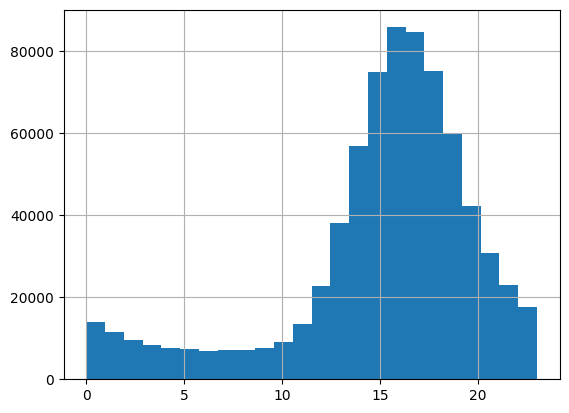

In [10]:
print('Storm reports by hour (local time)')
severe_df['EFFECTIVE'].dt.hour.hist(bins=24)

<Axes: >

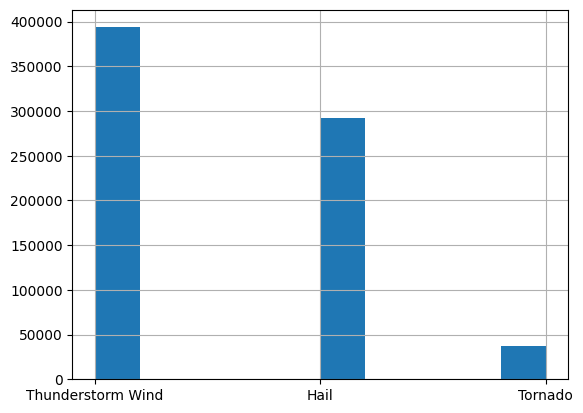

In [11]:
severe_df['EVENT_TYPE'].hist()

<Axes: xlabel='Rating'>

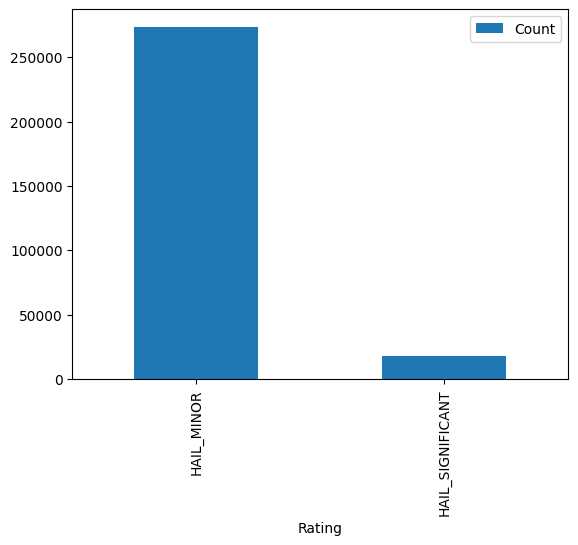

In [12]:
df = pd.DataFrame(severe_df[['HAIL_MINOR', 'HAIL_SIGNIFICANT']].sum(), columns=['Count'])
df.index.name = 'Rating'
df.plot(kind='bar')

<Axes: xlabel='Rating'>

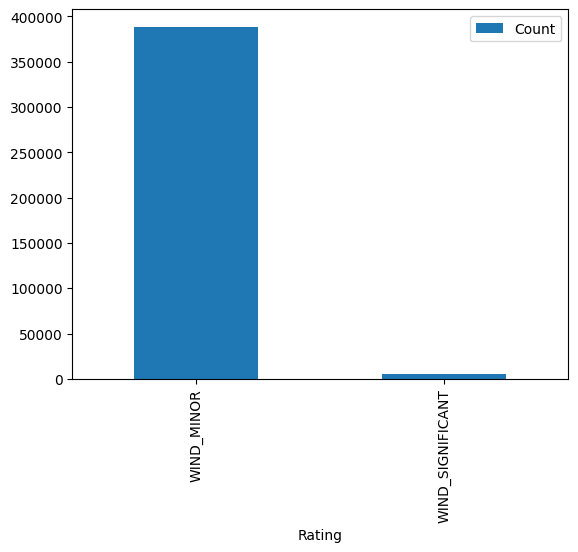

In [13]:
df = pd.DataFrame(severe_df[['WIND_MINOR', 'WIND_SIGNIFICANT']].sum(), columns=['Count'])
df.index.name = 'Rating'
df.plot(kind='bar')

<Axes: xlabel='Rating'>

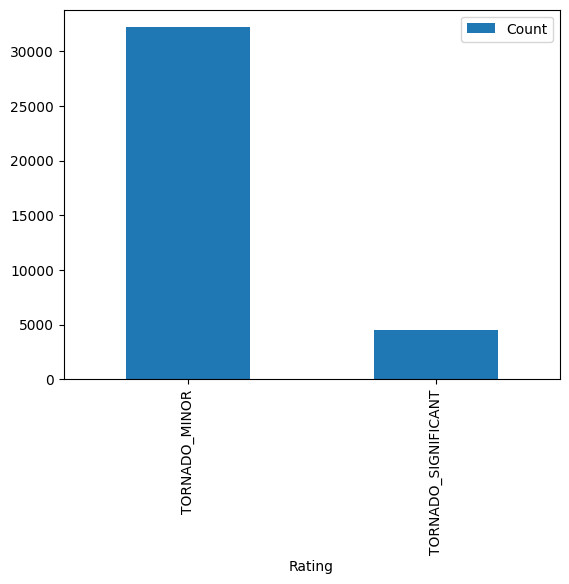

In [14]:
df = pd.DataFrame(severe_df[['TORNADO_MINOR', 'TORNADO_SIGNIFICANT']].sum(), columns=['Count'])
df.index.name = 'Rating'
df.plot(kind='bar')

In [15]:
severe_df.to_csv(f'{SILVER_PATH}/stormevents/csvfiles/severe_records.csv', index=False, float_format='%.4f', columns=out_columns)